<a href="https://colab.research.google.com/github/Emadrust/STLF-using-ANN/blob/main/Short_Term_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# 1. Data Loading and Preprocessing
df = pd.read_csv('gdrive/My Drive/Project/continuous dataset.csv')

In [4]:
# Set datetime index
df.index = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

<Axes: xlabel='datetime'>

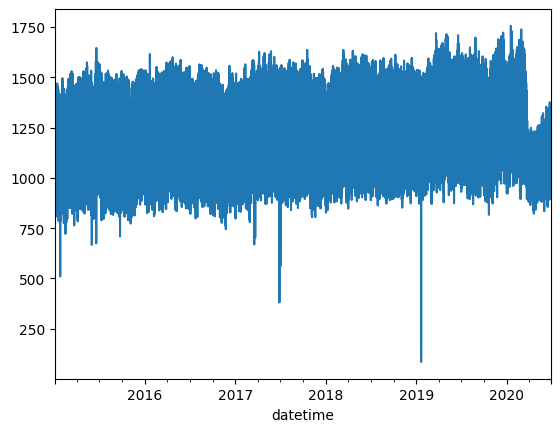

In [5]:
# Plotting National Demand
load = df['nat_demand']
load.plot()


# 2. Feature Engineering

In [6]:
# Create DataFrame with National Demand and add time-based features
load_df = pd.DataFrame({'Nat demand': load})
load_df['Seconds'] = load_df.index.map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day

load_df['Day sin'] = np.sin(load_df['Seconds'] * (2 * np.pi / day))
load_df['Day cos'] = np.cos(load_df['Seconds'] * (2 * np.pi / day))
load_df['Year sin'] = np.sin(load_df['Seconds'] * (2 * np.pi / year))
load_df['Year cos'] = np.cos(load_df['Seconds'] * (2 * np.pi / year))
load = load_df.drop('Seconds', axis=1)

In [7]:
# Combine all features into a final DataFrame
load_final_df = pd.concat([
    load,
    df['QV2M_toc'], df['W2M_toc'], df['TQL_toc'], df['T2M_toc'],
    df['QV2M_dav'], df['W2M_dav'], df['TQL_dav'], df['T2M_dav'],
    df['QV2M_san'], df['W2M_san'], df['TQL_san'], df['T2M_san'],
    df['Holiday_ID'], df['holiday'], df['school']
], axis=1)

In [8]:
# One-hot encoding of binary variables
load_final_df['holiday'] = pd.Categorical(load_final_df['holiday'])
load_final_df['school'] = pd.Categorical(load_final_df['school'])
load_final_df['school'] = pd.Categorical(load_final_df['Holiday_ID'])
load_final_df = pd.get_dummies(load_final_df, columns=['holiday', 'school', 'Holiday_ID'])

In [9]:
# 3. Data Splitting and Scaling
def df_to_X_y(df, window_size=10):
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = [df_as_np[i + window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)

X1, y1 = df_to_X_y(load_final_df)

In [10]:
# Split the data into training, validation, and test sets
X1_train, y1_train = X1[:33630], y1[:33630]
X1_val, y1_val = X1[33630:38434], y1[33630:38434]
X1_test, y1_test = X1[38434:], y1[38434:]


In [11]:
# Initialize the scalers
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

In [12]:
# Reshape and fit the input scaler on the training data
n_train_samples, n_timesteps, n_features = X1_train.shape
X1_train_reshaped = X1_train.reshape(-1, n_features)
input_scaler.fit(X1_train_reshaped)

MinMaxScaler()

In [13]:
# Transform the training, validation, and test input data
X1_train_scaled = input_scaler.transform(X1_train_reshaped).reshape(n_train_samples, n_timesteps, n_features)
n_val_samples = X1_val.shape[0]
X1_val_scaled = input_scaler.transform(X1_val.reshape(-1, n_features)).reshape(n_val_samples, n_timesteps, n_features)
n_test_samples = X1_test.shape[0]
X1_test_scaled = input_scaler.transform(X1_test.reshape(-1, n_features)).reshape(n_test_samples, n_timesteps, n_features)

In [14]:
# Fit the output scaler on the training outputs
y1_train = y1_train.reshape(-1, 1)
output_scaler.fit(y1_train)

MinMaxScaler()

In [15]:
# Transform the training, validation, and test output data
y1_train_scaled = output_scaler.transform(y1_train)
y1_val = y1_val.reshape(-1, 1)
y1_val_scaled = output_scaler.transform(y1_val)
y1_test = y1_test.reshape(-1, 1)
y1_test_scaled = output_scaler.transform(y1_test)

In [16]:
# 4. Model Building and Training
def build_and_train_model(model, cp_path, X_train, y_train, X_val, y_val):
    cp = ModelCheckpoint(cp_path, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp, es])
    return model


In [17]:
# Model 1: LSTM-based Model
model1 = Sequential()
model1.add(InputLayer((10, 65)))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

model1 = build_and_train_model(model1, 'model1/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,969 (179.57 KB)

 Trainable params: 45,969 (179.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0485 - root_mean_squared_error: 0.1980 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 7/50
1051/1051 ━━━━━━━

In [18]:
# Model 2: Conv1D-based Model
model2 = Sequential()
model2.add(InputLayer((10, 65)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

model2 = build_and_train_model(model2, 'model2/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 9, 64)               │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           4,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,009 (50.82 KB)

 Trainable params: 13,009 (50.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2226 - root_mean_squared_error: 0.4182 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 7/50
1051/1051 ━━━━━━━━━━━━━━━━━━━

In [19]:
# Model 3: GRU-based Model
model3 = Sequential()
model3.add(InputLayer((10, 65)))
model3.add(GRU(64, return_sequences=True))
model3.add(GRU(32))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

model3 = build_and_train_model(model3, 'model3/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          25,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,833 (136.07 KB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0749 - root_mean_squared_error: 0.2448 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0043 - root_mean_squared_error: 0.0651 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 9.6644e-04 - root_mean_squared_error: 0.0311 - val_loss: 9.9067e-04 - val_root_mean_squared_error: 0.0315
Epoch 7/50
1051/1051

In [20]:
# Model 4: Simplified LSTM Model
model4 = Sequential()
model4.add(InputLayer((10, 65)))
model4.add(LSTM(32))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

model4 = build_and_train_model(model4, 'model4/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,817 (50.07 KB)

 Trainable params: 12,817 (50.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0569 - root_mean_squared_error: 0.2192 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 7/50
1051/1051 ━━━━━━━━━━━━━━━

In [21]:
# Model 5: Conv1D with MaxPooling
model5 = Sequential()
model5.add(InputLayer((10, 65)))
model5.add(Conv1D(64, kernel_size=2, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Flatten())
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))
model5.summary()

model5 = build_and_train_model(model5, 'model5/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 9, 64)               │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,449 (40.82 KB)

 Trainable params: 10,449 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0460 - root_mean_squared_error: 0.1978 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 7/50
1051/1051 ━━━━━━━━━━━━━━━━━━━

In [22]:
# Model 6: Simplified GRU Model
model6 = Sequential()
model6.add(InputLayer((10, 65)))
model6.add(GRU(32))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

model6 = build_and_train_model(model6, 'model6/.keras', X1_train_scaled, y1_train_scaled, X1_val_scaled, y1_val_scaled)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 32)                  │           9,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,777 (38.19 KB)

 Trainable params: 9,777 (38.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1416 - root_mean_squared_error: 0.3442 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0032 - root_mean_squared_error: 0.0561 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 7/50
1051/1051 ━━━━━━━━━━━━

In [23]:
# 5. Model Evaluation and Prediction Visualization
def plot_predictions(model, X, y, start=0, end=100, datetime_index=None):
    predictions_scaled = model.predict(X).flatten()
    predictions_original = output_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    actuals_original = output_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

    df = pd.DataFrame(data={
        'Predictions': predictions_original[start:end],
        'Actuals': actuals_original[start:end]
    })

    if datetime_index is not None:
        datetime_index_slice = datetime_index[start:end]
        df.index = datetime_index_slice

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Actuals'], label="Actuals")
    plt.plot(df.index, df['Predictions'], label="Predictions")
    plt.xlabel('Datetime')
    plt.ylabel('Load')
    plt.title('Predictions vs Actuals')
    plt.legend(loc="lower left")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    return df, mse(predictions_original[start:end], actuals_original[start:end])

In [24]:
# Extract the datetime index corresponding to your test data
datetime_test_index = df.index[-len(X1_test_scaled):]

In [26]:
# 5. Model Evaluation

print("Evaluating Model 1 (LSTM-based):")
model1.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

print("\nEvaluating Model 2 (Conv1D-based):")
model2.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

print("\nEvaluating Model 3 (GRU-based):")
model3.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

print("\nEvaluating Model 4 (Simplified LSTM):")
model4.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

print("\nEvaluating Model 5 (Conv1D with MaxPooling):")
model5.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

print("\nEvaluating Model 6 (Simplified GRU):")
model6.evaluate(X1_test_scaled, y1_test_scaled, batch_size=64, verbose=2)

Evaluating Model 1 (LSTM-based):
151/151 - 1s - 6ms/step - loss: 5.0185e-04 - root_mean_squared_error: 0.0224

Evaluating Model 2 (Conv1D-based):
151/151 - 0s - 2ms/step - loss: 6.5285e-04 - root_mean_squared_error: 0.0256

Evaluating Model 3 (GRU-based):
151/151 - 1s - 5ms/step - loss: 6.1988e-04 - root_mean_squared_error: 0.0249

Evaluating Model 4 (Simplified LSTM):
151/151 - 0s - 3ms/step - loss: 5.9829e-04 - root_mean_squared_error: 0.0245

Evaluating Model 5 (Conv1D with MaxPooling):
151/151 - 0s - 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433

Evaluating Model 6 (Simplified GRU):
151/151 - 0s - 3ms/step - loss: 4.9513e-04 - root_mean_squared_error: 0.0223


[0.0004951336304657161, 0.02225159853696823]

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


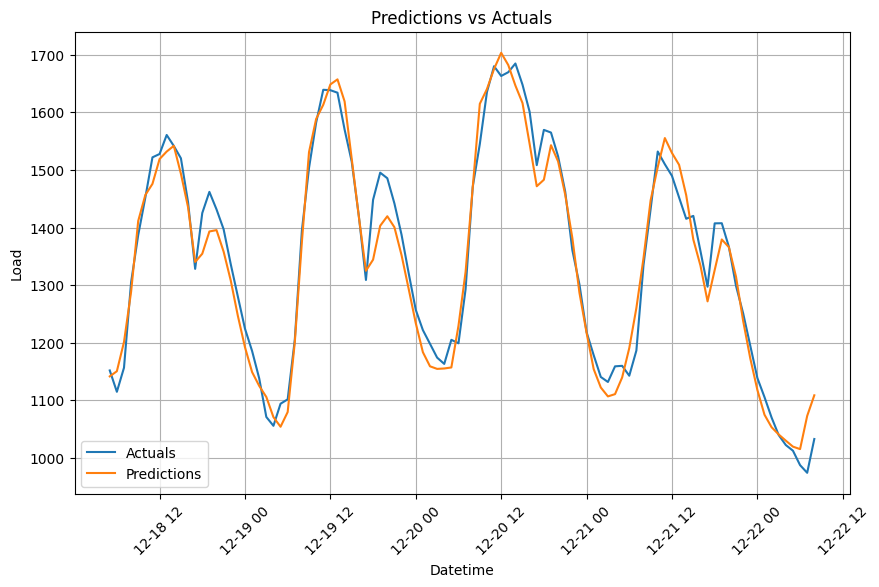

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1141.528442  1151.8148
 2019-12-18 06:00:00  1150.477173  1114.7327
 2019-12-18 07:00:00  1201.145020  1156.5203
 2019-12-18 08:00:00  1288.580444  1305.0949
 2019-12-18 09:00:00  1411.487427  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1029.849487  1022.2492
 2019-12-22 05:00:00  1019.500916  1012.4287
 2019-12-22 06:00:00  1015.218811   987.3988
 2019-12-22 07:00:00  1072.879517   974.0660
 2019-12-22 08:00:00  1108.651245  1032.7715
 
 [100 rows x 2 columns],
 1428.651846426778)

In [27]:
# Plot predictions for each model
plot_predictions(model1, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


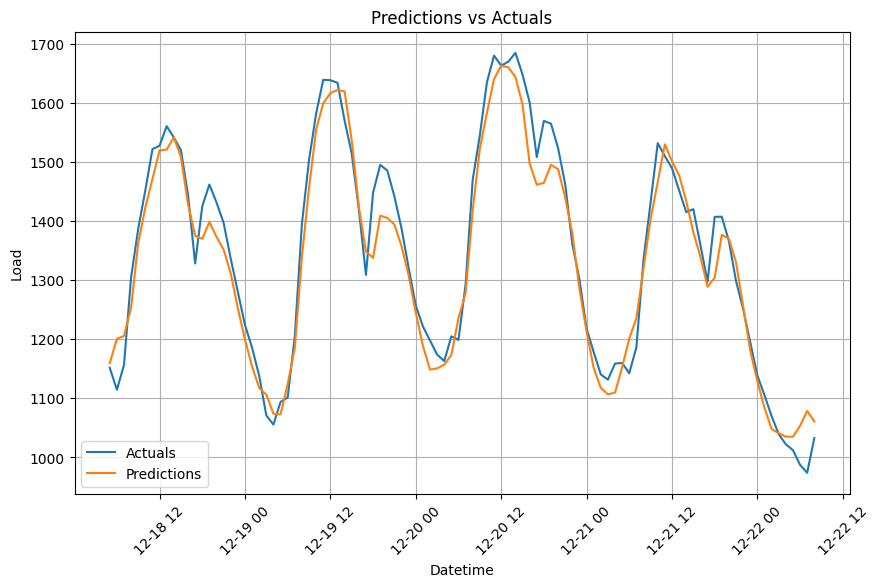

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1159.617065  1151.8148
 2019-12-18 06:00:00  1200.721802  1114.7327
 2019-12-18 07:00:00  1205.703247  1156.5203
 2019-12-18 08:00:00  1253.971069  1305.0949
 2019-12-18 09:00:00  1363.224731  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1035.264282  1022.2492
 2019-12-22 05:00:00  1035.046387  1012.4287
 2019-12-22 06:00:00  1053.550293   987.3988
 2019-12-22 07:00:00  1078.773682   974.0660
 2019-12-22 08:00:00  1060.969727  1032.7715
 
 [100 rows x 2 columns],
 1810.5867742545076)

In [28]:
plot_predictions(model2, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


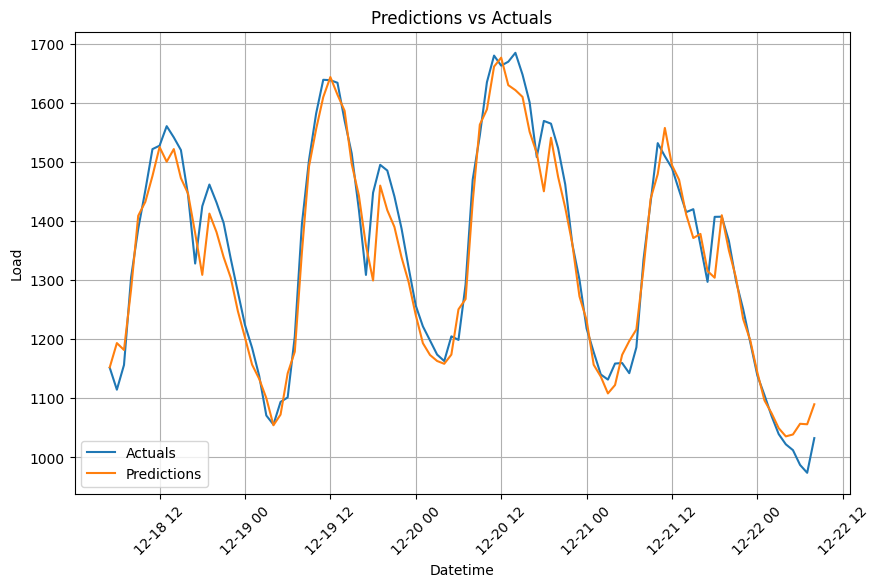

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1152.620483  1151.8148
 2019-12-18 06:00:00  1193.606323  1114.7327
 2019-12-18 07:00:00  1181.950439  1156.5203
 2019-12-18 08:00:00  1284.676758  1305.0949
 2019-12-18 09:00:00  1409.043457  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1035.714600  1022.2492
 2019-12-22 05:00:00  1038.930542  1012.4287
 2019-12-22 06:00:00  1057.020142   987.3988
 2019-12-22 07:00:00  1056.210938   974.0660
 2019-12-22 08:00:00  1090.053467  1032.7715
 
 [100 rows x 2 columns],
 1714.6314465036482)

In [29]:
plot_predictions(model3, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


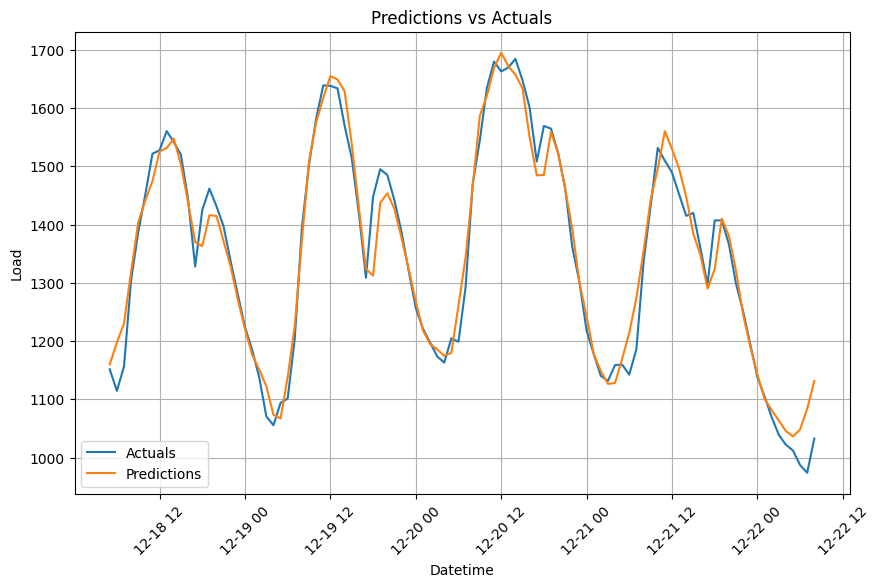

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1160.298584  1151.8148
 2019-12-18 06:00:00  1197.783813  1114.7327
 2019-12-18 07:00:00  1230.149658  1156.5203
 2019-12-18 08:00:00  1319.687744  1305.0949
 2019-12-18 09:00:00  1403.859253  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1045.941528  1022.2492
 2019-12-22 05:00:00  1036.487305  1012.4287
 2019-12-22 06:00:00  1048.394165   987.3988
 2019-12-22 07:00:00  1083.897217   974.0660
 2019-12-22 08:00:00  1131.626343  1032.7715
 
 [100 rows x 2 columns],
 1432.4066592804)

In [30]:
plot_predictions(model4, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


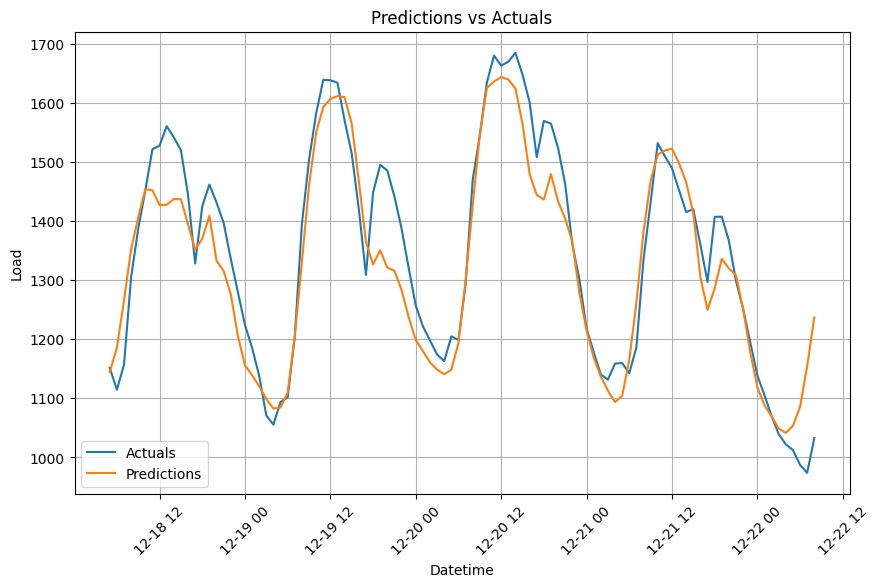

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1144.486938  1151.8148
 2019-12-18 06:00:00  1185.549805  1114.7327
 2019-12-18 07:00:00  1265.728394  1156.5203
 2019-12-18 08:00:00  1352.291504  1305.0949
 2019-12-18 09:00:00  1406.183838  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1041.699951  1022.2492
 2019-12-22 05:00:00  1053.745483  1012.4287
 2019-12-22 06:00:00  1085.690918   987.3988
 2019-12-22 07:00:00  1154.683838   974.0660
 2019-12-22 08:00:00  1237.291748  1032.7715
 
 [100 rows x 2 columns],
 4498.03738371746)

In [31]:
plot_predictions(model5, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


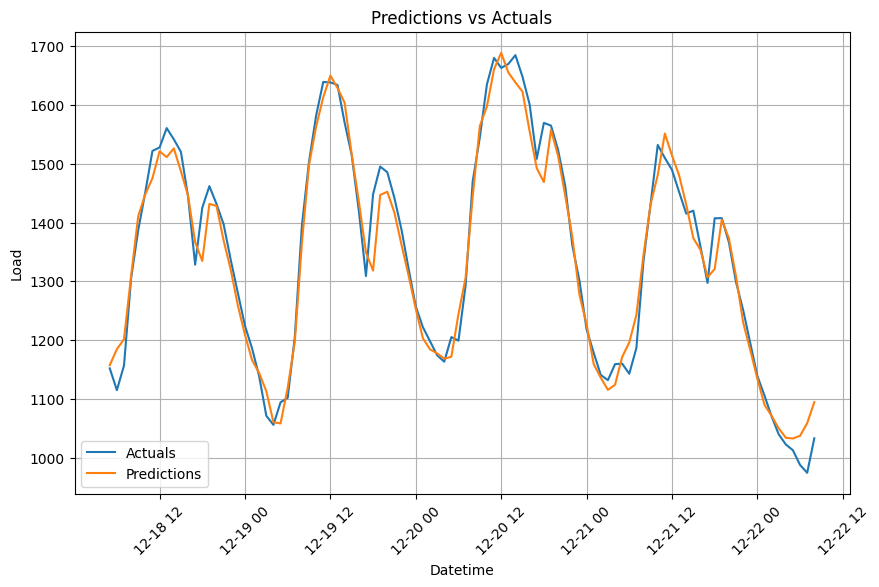

(                     Predictions    Actuals
 datetime                                   
 2019-12-18 05:00:00  1157.111328  1151.8148
 2019-12-18 06:00:00  1184.455322  1114.7327
 2019-12-18 07:00:00  1201.381470  1156.5203
 2019-12-18 08:00:00  1309.162842  1305.0949
 2019-12-18 09:00:00  1411.009644  1387.0419
 ...                          ...        ...
 2019-12-22 04:00:00  1033.686890  1022.2492
 2019-12-22 05:00:00  1032.487183  1012.4287
 2019-12-22 06:00:00  1037.055908   987.3988
 2019-12-22 07:00:00  1058.591187   974.0660
 2019-12-22 08:00:00  1094.337646  1032.7715
 
 [100 rows x 2 columns],
 1196.6735867347647)

In [32]:
plot_predictions(model6, X1_test_scaled, y1_test_scaled, 5000, 5100, datetime_index=datetime_test_index)